In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from IPython.display import HTML
#https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
import contextily as ctx

%matplotlib inline

In [2]:
df = pd.read_csv('sample_histogram_parks2buildings_distance_NY.csv',sep=",")
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'].apply(wkt.loads))
gdf.head()

,geohash,count_buildings,distance_park,geometry
0,dr5nqqsgce74wrhuct7n,25,1050.0,"POLYGON ((-74.2450000000001 40.5049999999999, ..."
1,dr5x2jtfjmdknp1tku13,5,990.0,"POLYGON ((-73.815 40.6750000000001, -73.815 40..."
2,dr5xfbmr9w2yjt69k1wk,32,990.0,"POLYGON ((-73.69499999999989 40.735, -73.69499..."
3,dr5nqws5fe7dxxnhyvkq,3,1080.0,"POLYGON ((-74.2349999999999 40.5049999999999, ..."
4,dr5x2jtfjmdknp1tku13,18,960.0,"POLYGON ((-73.815 40.6750000000001, -73.815 40..."


## Plot WGS84

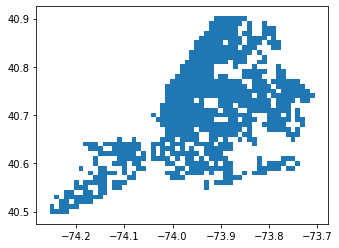

In [3]:
gdf[gdf.distance_park==0].plot()

## Calculate projected geometries

In [4]:
gdf.crs = {'init': 'epsg:4326'}
gdf_proj = gdf.to_crs(epsg=3857)
gdf_proj.head()

,geohash,count_buildings,distance_park,geometry
0,dr5nqqsgce74wrhuct7n,25,1050.0,POLYGON ((-8264915.593946608 4939601.177142415...
1,dr5x2jtfjmdknp1tku13,5,990.0,POLYGON ((-8217048.212905489 4964521.782140095...
2,dr5xfbmr9w2yjt69k1wk,32,990.0,"POLYGON ((-8203689.874010283 4973332.45235228,..."
3,dr5nqws5fe7dxxnhyvkq,3,1080.0,POLYGON ((-8263802.399038652 4939601.177142415...
4,dr5x2jtfjmdknp1tku13,18,960.0,POLYGON ((-8217048.212905489 4964521.782140095...


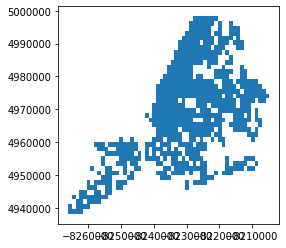

In [5]:
gdf_proj[gdf_proj.distance_park==0].plot()

## Plot projected
https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

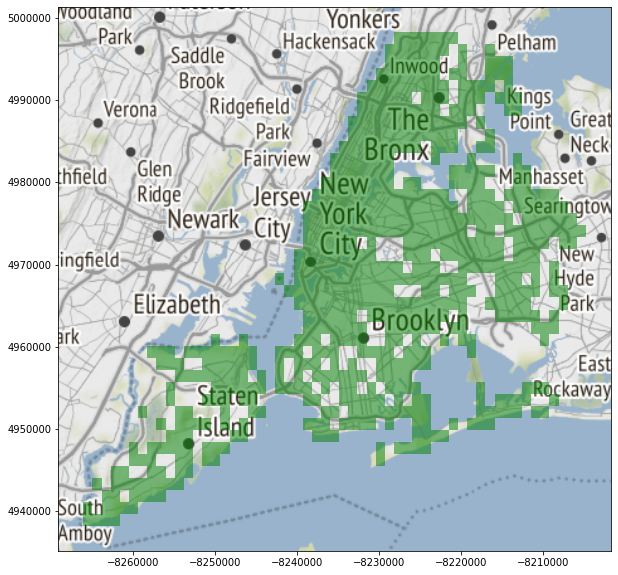

In [6]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

ax = gdf_proj[gdf_proj.distance_park==0].plot(figsize=(10, 10), alpha=.5, color='green')
add_basemap(ax, zoom=10)

## Aggregate distances

In [7]:
gdf_proj_total = gdf_proj.groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})

distance = 60
gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total
gdf_proj_distance.head()

,count_buildings,geometry,count_buildings_total,ratio
geohash,,,,
dr5nqkuc9e5nqkuc9e5n,89,POLYGON ((-8264915.593946608 4938137.228986094...,313,0.284345
dr5nqqsgce74wrhuct7n,37,POLYGON ((-8264915.593946608 4939601.177142415...,1274,0.029042
dr5nqsu1de5wrsy1wghq,158,POLYGON ((-8263802.399038652 4938137.228986094...,974,0.162218
dr5nqug3eehq2uz9s5jq,64,POLYGON ((-8262689.204130731 4938137.228986094...,89,0.719101
dr5nqye7gek68zpsujmq,245,POLYGON ((-8262689.204130731 4939601.177142415...,378,0.648148


## Plot animation

In [8]:
fig, ax = plt.subplots(figsize=(9,9))
plt.axis('off');

plt.suptitle('Animate distance from Tokyo buildings to nearest parks', fontsize=18)

xmin, ymin, xmax, ymax = gdf_proj.geometry.total_bounds
basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=10,
                                 url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png')
ax.imshow(basemap, extent=extent, interpolation='bilinear')
ax.axis((xmin, xmax, ymin, ymax))

ims = []
def updatefig(j):
    global ims, ax
    for im in ims:
        im.remove()
    # distances defined as 0m, 30m, 60m, ...
    distance = 30*j
    ax.set_title('%d meters or less' % (distance + 30), fontsize=18)
    
    gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
    gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
    gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total

    # high ration
    gdf_subset = gdf_proj_distance[gdf_proj_distance.ratio>=0.8]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='green',alpha=0.5,edgecolor='None')
    im1 = ax.add_collection(coll)
    
    # medium ratio
    gdf_subset = gdf_proj_distance[(gdf_proj_distance.ratio<0.8)&(gdf_proj_distance.ratio>=0.5)]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='yellow',alpha=0.3,edgecolor='None')
    im2 = ax.add_collection(coll)
    
    # low ratio
    gdf_subset = gdf_proj_distance[gdf_proj_distance.ratio<0.5]
    patches = [PolygonPatch(geom) for geom in gdf_subset.geometry]
    coll = PatchCollection(patches,color='red',alpha=0.3,edgecolor='None')
    im3 = ax.add_collection(coll)
    
    ims = [im1,im2,im3]
    return

anim = animation.FuncAnimation(fig, updatefig, frames=range(20), interval=500)
plt.close(anim._fig)
HTML(anim.to_html5_video())